In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

import numpy as np
import pandas as pd
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Baixar o recurso 'punkt' do NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Configuração do ambiente Kaggle
KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Download e extração dos dados
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'job-recommendation-datasets:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F174180%2F393357%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240724%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240724T184840Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D67ac075cb622f73d7fbc927b9d5e5727696e02b02c96eb2d2c1df2bb95618c7f05fa0f66c3f28f34a5e00b7c0ecba51512e8dd11a871200d5b2ab425a76214f122f24aa53714da983fa8cd2864256b39f53ac3b22cd86365e10a9e2e1c2198a5d74b87404af98c275827da10f6c89b1ebc10ad25e9a0b6bc5f611c2443db29c1f72478749860a15a75478e72f57eae89ab85c9fe07f914892066ff1fb46266b96f7b50656556fafef7094b6bf1f7f33226a92b6c873bd64084d9f4ebf37af799141ec843bf88a3d0a93aabd57972df198b2e769fe53d40ef19c62316477f9431205f50747be9219e94e83a2b91ad0afa6e10eef54527537c6f7d05855da453bf'

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 54900687 bytes downloaded
Downloaded and uncompressed: job-recommendation-datasets
Data source import complete.


In [ ]:
# Carregar dataset
df = pd.read_csv('/kaggle/input/job-recommendation-datasets/Combined_Jobs_Final.csv')

# Exibir as primeiras linhas do dataset para visualizar os dados
print("Primeiras linhas do dataset original:")
print(df.head())
df.info()

# Selecionar as colunas de interesse - Selecionei apenas dois para realizar o teste
df_old = df[['Title', 'Job.Description']]

# Selecionar as primeiras 10000 linhas para reduzir o tamanho do dataset
df = df_old.head(10000).copy()

# Exibir as primeiras linhas do dataset reduzido
print("\nPrimeiras linhas do dataset reduzido:")
print(df.head())


Primeiras linhas do dataset original:
   Job.ID  Provider Status                                               Slug  \
0     111         1   open                    palo-alto-ca-tacolicious-server   
1     113         1   open    san-francisco-ca-claude-lane-kitchen-staff-chef   
2     117         1   open  san-francisco-ca-machka-restaurants-corp-barte...   
3     121         1   open                  brisbane-ca-teriyaki-house-server   
4     127         1   open  los-angeles-ca-rosa-mexicano-sunset-kitchen-st...   

                                         Title            Position  \
0                         Server @ Tacolicious              Server   
1             Kitchen Staff/Chef @ Claude Lane  Kitchen Staff/Chef   
2         Bartender @ Machka Restaurants Corp.           Bartender   
3                      Server @ Teriyaki House              Server   
4  Kitchen Staff/Chef @ Rosa Mexicano - Sunset  Kitchen Staff/Chef   

                    Company           City  State.Name

In [ ]:
# Inicializar o PorterStemmer
# O stemming é o processo de reduzir palavras ao seu radical ou forma base. Por exemplo, as
#palavras "running", "runner" e "ran" são todas reduzidas à raiz "run".
ps = PorterStemmer()

# Função de limpeza do texto
def cleaning(txt):
    cleaned_txt = re.sub(r'[^a-zA-Z0-9\s]', '', txt)
    tokens = nltk.word_tokenize(cleaned_txt.lower()) # MI - DIVI
    #CRIAR UMA LISTA QUE REMOVA OS E,O, AS
    stemming = [ps.stem(word) for word in tokens if word not in stopwords.words('english')]
    #JOGANDO EM UMA UNICA STRING EM ESPAÇO
    return " ".join(stemming)

# Aplicar a função de limpeza na coluna 'Title'
df['Title'] = df['Title'].apply(lambda x: cleaning(x))

# Converter a coluna 'Job.Description' para string e aplicar a função de limpeza
df['Job.Description'] = df['Job.Description'].astype(str).apply(lambda x: cleaning(x))

# Exibir as primeiras linhas do dataset após limpeza
print("\nPrimeiras linhas do dataset após limpeza:")
print(df.head())



Primeiras linhas do dataset após limpeza:
                                    Title  \
0                         server tacolici   
1            kitchen staffchef claud lane   
2             bartend machka restaur corp   
3                    server teriyaki hous   
4  kitchen staffchef rosa mexicano sunset   

                                     Job.Description  
0  tacolici first palo alto store open recent hir...  
1  new french brasseri sf financi district seek c...  
2  popular mediterranean wine bar restaur financi...  
3  serv fooddrink custom profession manner act ca...  
4  locat heart hollywood one popular mexican plac...  


In [ ]:
# Criar uma nova coluna combinando 'Title' e 'Job.Description'
df['new_col'] = df['Title'] + " " + df['Job.Description']

# Exibir as primeiras linhas do dataset com a nova coluna
print("\nPrimeiras linhas do dataset com nova coluna combinada:")
print(df.head())


Primeiras linhas do dataset com nova coluna combinada:
                                    Title  \
0                         server tacolici   
1            kitchen staffchef claud lane   
2             bartend machka restaur corp   
3                    server teriyaki hous   
4  kitchen staffchef rosa mexicano sunset   

                                     Job.Description  \
0  tacolici first palo alto store open recent hir...   
1  new french brasseri sf financi district seek c...   
2  popular mediterranean wine bar restaur financi...   
3  serv fooddrink custom profession manner act ca...   
4  locat heart hollywood one popular mexican plac...   

                                             new_col  
0  server tacolici tacolici first palo alto store...  
1  kitchen staffchef claud lane new french brasse...  
2  bartend machka restaur corp popular mediterran...  
3  server teriyaki hous serv fooddrink custom pro...  
4  kitchen staffchef rosa mexicano sunset locat h...  


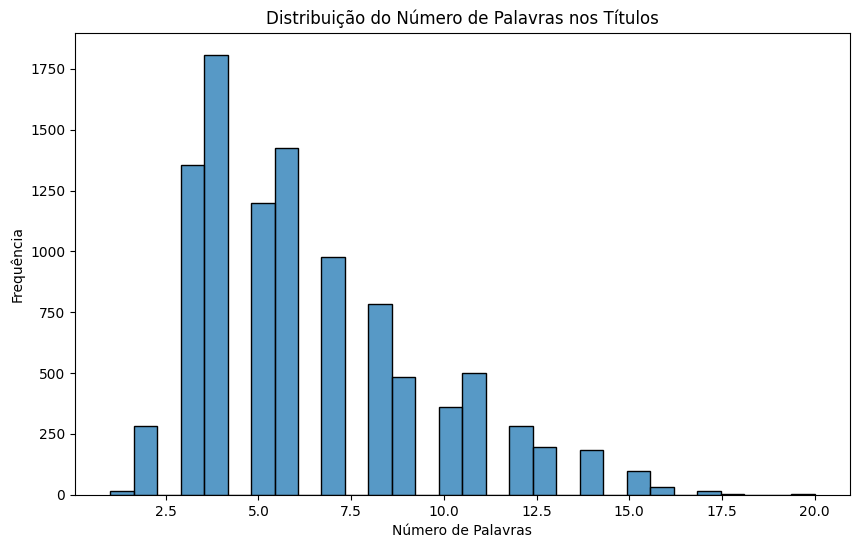

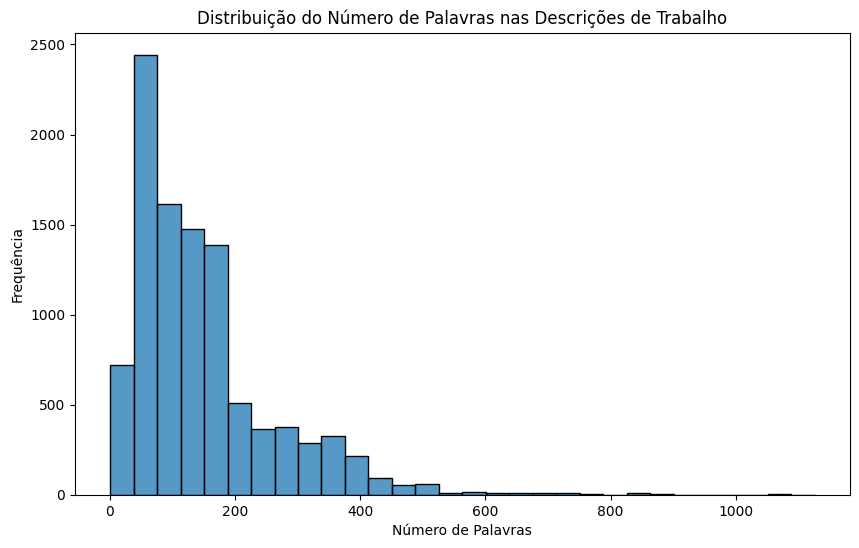

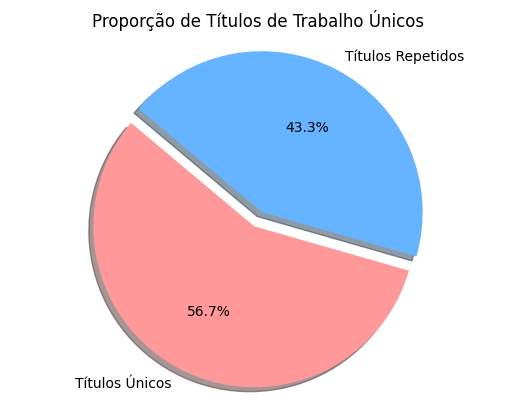

In [ ]:
# Gráfico de contagem de palavras no título
df['Title_length'] = df['Title'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['Title_length'], kde=False, bins=30)
plt.title('Distribuição do Número de Palavras nos Títulos')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.show()

# Gráfico de contagem de palavras na descrição do trabalho
df['Job_Description_length'] = df['Job.Description'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['Job_Description_length'], kde=False, bins=30)
plt.title('Distribuição do Número de Palavras nas Descrições de Trabalho')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.show()

# Gráfico de pizza da proporção de títulos de trabalho únicos
unique_titles = df['Title'].nunique()
total_titles = df['Title'].size
labels = ['Títulos Únicos', 'Títulos Repetidos']
sizes = [unique_titles, total_titles - unique_titles]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode 1st slice

# Correção do formato do autopct
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proporção de Títulos de Trabalho Únicos')
plt.show()



In [ ]:
# Vetorização usando TF-IDF
tfidf = TfidfVectorizer()

# Ajustar e transformar os dados da nova coluna em uma matriz TF-IDF
matrix = tfidf.fit_transform(df['new_col'])

# Calcular a similaridade coseno entre os vetores TF-IDF
similarity = cosine_similarity(matrix)


In [ ]:
# Função para recomendar títulos similares
def recommendation(title):
    try:
        idx = df[df['Title'] == title].index[0]
        y = sorted(list(enumerate(similarity[idx])), key=lambda x: x[1], reverse=True)
        top_20 = y[1:21]
        jobs = [df.iloc[i[0]].Title for i in top_20]
        return jobs
    except IndexError:
        return "No recommendations found for this title."

# Testar a função de recomendação com um exemplo
print("\nRecomendações para 'medic front offic officeteam':")
print(recommendation('medic front offic officeteam'))



Recomendações para 'medic front offic officeteam':
['medic front offic specialist officeteam', 'medic front desk coordin officeteam', 'medic administr assistantreceptionist officeteam', 'medic administr assist receptionist officeteam', 'medic receptionist officeteam', 'medic receptionist need asap officeteam', 'front desk coordin officeteam', 'front desk coordin officeteam', 'front desk coordin officeteam', 'receptionist officeteam', 'patient focus medic assist need asap officeteam', 'front desk receptionist officeteam', 'talent custom servic repres need officeteam', 'front desk coordin officeteam', 'receptionist a1 imag aventura', 'administr assist officeteam', 'receptionist officeteam', 'receptionist officeteam', 'receptionist officeteam', 'receptionist officeteam']


In [ ]:
import pandas as pd

# Definir a quantidade máxima de linhas a serem exibidas
pd.set_option('display.max_rows', None)

# Exibir a coluna Title
print(df['Title'])



0                                         server tacolici
1                            kitchen staffchef claud lane
2                             bartend machka restaur corp
3                                    server teriyaki hous
4                  kitchen staffchef rosa mexicano sunset
5                        receptionist mind beauti day spa
6                                server roy woodland hill
7                                     driver koja kitchen
8                     assist store manag king food market
9             store associ retail sale custom servic aldi
10      maci season retail commiss sale women shoe par...
11                   part time clerk need kroger louisvil
12      flex part time merchandis mullin sc cocacola b...
13                        child psychotherapist catch inc
14                   part time clerk need kroger louisvil
15      hire kitchen posit experienc line cook longhor...
16                      hr administr new york commun bank
17      retail

In [ ]:
#Vou salvar no drive
save_path = '/content/drive/MyDrive/Colab Notebooks/'

# Salvar os dados e o modelo de similaridade em arquivos pickle para uso posterior
pickle.dump(df, open(save_path + 'df.pkl', 'wb'))
pickle.dump(similarity, open(save_path + 'similarity.pkl', 'wb'))

In [ ]:
# Carregar os dados e o modelo de similaridade
df = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/df.pkl', 'rb'))
similarity = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/similarity.pkl', 'rb'))

In [ ]:
# Testar a função de recomendação com um novo título
new_title = 'lpn pinevil rehabilit live center'
print(f"\nRecomendações para '{new_title}':")
print(recommendation(new_title))



Recomendações para 'lpn pinevil rehabilit live center':
['lpn licens practic nurs nurs home lpn wingat healthcar', 'night nurs licens practic nurs lpn healthcar nurs full part time henderson nurs rehabilit center', 'rn lpn nurs open ft 210 pt 106 altoona nurs rehabilit center', 'licens practic nurs lpn advanc care staf', 'licens practic nurs lpn clark counti home care black stone', 'licens practic nurs lpn night bayada home health care', 'lpn licens practic nurs communicar health servic', 'licens practic nursedermatolog clinic parttim day shift gradi health system', 'rn lpn regist licens practic nurs maxim healthcar servic inc', 'lpn licens practic nurs healthcar primecar medic inc', 'rn lpn regist licens practic nurs maxim healthcar servic inc', 'rn lpn regist licens practic nurs maxim healthcar servic inc', 'rn lpn regist licens practic nurs maxim healthcar servic inc', 'licens practic nurs lpn trilog health servic', 'clinic nurs lpn consul health care', 'rn lpn regist licens practi